# 数据集定义与加载


深度学习模型需要大量的数据来完成训练和评估，这些数据样本可能是图片（image）、文本（text）、语音（audio）等多种类型，而模型训练过程实际是数学计算过程，因此数据样本在送入模型前需要经过一系列处理，如转换数据格式、划分数据集、变换数据形状（shape）、制作数据迭代读取器以备分批训练等。

在飞桨框架中，可通过如下两个核心步骤完成数据集的定义与加载：

1. **定义数据集**：将磁盘中保存的原始图片、文字等样本和对应的标签映射到 Dataset，方便后续通过索引（index）读取数据，在 Dataset 中还可以进行一些数据变换、数据增广等预处理操作。在飞桨框架中推荐使用 [paddle.io.Dataset](../../api/paddle/io/Dataset_cn.html#dataset) 自定义数据集，另外在 [paddle.vision.datasets](../../api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](../../api/paddle/text/Overview_cn.html#api) 目录下飞桨内置了一些经典数据集方便直接调用。


2. **迭代读取数据集**：自动将数据集的样本进行分批（batch）、乱序（shuffle）等操作，方便训练时迭代读取，同时还支持多进程异步读取功能可加快数据读取速度。在飞桨框架中可使用 [paddle.io.DataLoader](../../api/paddle/io/DataLoader_cn.html#dataloader) 迭代读取数据集。


本文以图像数据集为例介绍，文本数据集可参考 [NLP 应用实践](../../practices/nlp/index_cn.html)。

## 一、定义数据集

### 1.1 直接加载内置数据集

飞桨框架在 [paddle.vision.datasets](../../api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](../..//api/paddle/text/Overview_cn.html#api) 目录下内置了一些经典数据集可直接调用，通过以下代码可查看飞桨框架中的内置数据集。

In [1]:
import paddle

print("计算机视觉（CV）相关数据集：", paddle.vision.datasets.__all__)
print("自然语言处理（NLP）相关数据集：", paddle.text.__all__)

计算机视觉（CV）相关数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']
自然语言处理（NLP）相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16', 'ViterbiDecoder', 'viterbi_decode']


从打印结果可以看到飞桨内置了 CV 领域的 MNIST、FashionMNIST、Flowers、Cifar10、Cifar100、VOC2012 数据集，以及 NLP 领域的 Conll05st、Imdb、Imikolov、Movielens、UCIHousing、WMT14、WMT16 数据集。


以 [MNIST](../../api/paddle/vision/datasets/MNIST_cn.html) 数据集为例，加载内置数据集的代码示例如下所示。

In [2]:
from paddle.vision.transforms import Normalize

# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")
# 下载数据集并初始化 DataSet
train_dataset = paddle.vision.datasets.MNIST(mode="train", transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode="test", transform=transform)
print(
    "train images: ", len(train_dataset), ", test images: ", len(test_dataset)
)

train images:  60000 , test images:  10000


内置的 [MNIST](../../api/paddle/vision/datasets/MNIST_cn.html) 数据集已经划分好了训练集和测试集，通过 `mode` 字段传入 `'train'` 或 `'test'` 来区分。

另外可通过 `transform` 字段传入一些对图像进行变换的操作，飞桨在 [paddle.vision.transforms](../..api/paddle/vision/Overview_cn.html#about-transforms) 下提供了一些常用的图像变换操作，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化等。这里在初始化 MNIST 数据集时传入了 `Normalize` 变换对图像进行归一化，对图像进行归一化可以加快模型训练的收敛速度。

完成数据集初始化之后，可以使用下面的代码直接对数据集进行迭代读取。

shape of image:  (1, 28, 28)


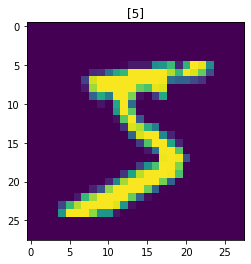

In [3]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print("shape of image: ", image.shape)
    plt.title(str(label))
    plt.imshow(image[0])
    break

### 1.2 使用 paddle.io.Dataset 自定义数据集

在实际的场景中，一般需要使用自有的数据来定义数据集，这时可以通过 [paddle.io.Dataset](../../api/paddle/io/Dataset_cn.html#dataset) 基类来实现自定义数据集。

可构建一个子类继承自 `paddle.io.Dataset` ，并且实现下面的三个函数：

1. `__init__`：完成数据集初始化操作，将磁盘中的样本文件路径和对应标签映射到一个列表中。
2. `__getitem__`：定义指定索引（index）时如何获取样本数据，最终返回对应 index 的单条数据（样本数据、对应的标签）。
3. `__len__`：返回数据集的样本总数。

下面介绍下载 MNIST 原始数据集文件后，用 `paddle.io.Dataset` 定义数据集的代码示例。



In [ ]:
# 下载原始的 MNIST 数据集并解压
! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
! tar -xf mnist.tar

In [4]:
import os
import cv2
import numpy as np
from paddle.io import Dataset
from paddle.vision.transforms import Normalize


class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """

    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super().__init__()
        self.data_list = []
        with open(label_path, encoding="utf-8") as f:
            for line in f.readlines():
                image_path, label = line.strip().split("\t")
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        image_path, label = self.data_list[index]
        # 读取灰度图
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype("float32")
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = int(label)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)


# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")
# 打印数据集样本数
train_custom_dataset = MyDataset(
    "mnist/train", "mnist/train/label.txt", transform
)
test_custom_dataset = MyDataset("mnist/val", "mnist/val/label.txt", transform)
print(
    "train_custom_dataset images: ",
    len(train_custom_dataset),
    "test_custom_dataset images: ",
    len(test_custom_dataset),
)

train_custom_dataset images:  60000 test_custom_dataset images:  10000


在上面的代码中，自定义了一个数据集类 `MyDataset`，`MyDataset` 继承自 `paddle.io.Dataset` 基类 ，并且实现了 `__init__`,`__getitem__` 和 `__len__` 三个函数。
* 在 `__init__` 函数中完成了对标签文件的读取和解析，并将所有的图像路径 `image_path` 和对应的标签 `label` 存放到一个列表 `data_list` 中。
* 在 `__getitem__` 函数中定义了指定 index 获取对应图像数据的方法，完成了图像的读取、预处理和图像标签格式的转换，最终返回图像和对应标签 `image, label`。
* 在 `__len__` 函数中返回 `__init__` 函数中初始化好的数据集列表 `data_list` 长度。




另外，在 `__init__` 函数和 `__getitem__` 函数中还可实现一些数据预处理操作，如对图像的翻转、裁剪、归一化等操作，最终返回处理好的单条数据（样本数据、对应的标签），该操作可增加图像数据多样性，对增强模型的泛化能力带来帮助。飞桨框架在 [paddle.vision.transforms](../..api/paddle/vision/Overview_cn.html#about-transforms)  下内置了几十种图像数据处理方法，详细使用方法可参考 [数据预处理](data_preprocessing_cn.html) 章节。

和内置数据集类似，可以使用下面的代码直接对自定义数据集进行迭代读取。

shape of image:  (1, 28, 28)


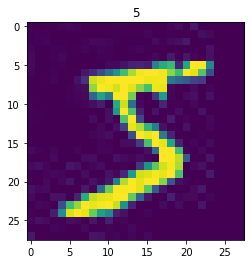

In [5]:
for data in train_custom_dataset:
    image, label = data
    print("shape of image: ", image.shape)
    plt.title(str(label))
    plt.imshow(image[0])
    break

## 二、迭代读取数据集

### 2.1 使用 paddle.io.DataLoader 定义数据读取器

通过前面介绍的直接迭代读取 Dataset 的方式虽然可实现对数据集的访问，但是这种访问方式只能单线程进行并且还需要手动分批次（batch）。在飞桨框架中，推荐使用 [paddle.io.DataLoader](../../api/paddle/io/DataLoader_cn.html#dataloader) API 对数据集进行多进程的读取，并且可自动完成划分 batch 的工作。

In [7]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(
    train_custom_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=1,
    drop_last=True,
)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print(
        "batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(
            batch_id, images.shape, labels.shape
        )
    )
    break

batch_id: 0, 训练数据shape: [64, 1, 28, 28], 标签数据shape: [64]


通过上述方法，初始化了一个数据读取器 `train_loader`，用于加载训练数据集 `train_custom_dataset`。在数据读取器中几个常用的字段如下：

* `batch_size`：**每批次读取样本数**，示例中 `batch_size=64` 表示每批次读取 64 个样本。
* `shuffle`：**样本乱序**，示例中 `shuffle=True` 表示在取数据时打乱样本顺序，以减少过拟合发生的可能。
* `drop_last`：**丢弃不完整的批次样本**，示例中 `drop_last=True` 表示丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的 batch 样本。
* `num_workers`：**同步/异步读取数据**，通过 `num_workers` 来设置加载数据的子进程个数，num_workers的值设为大于0时，即开启多进程方式异步加载数据，可提升数据读取速度。


定义好数据读取器之后，便可用 for 循环方便地迭代读取批次数据，用于模型训练了。值得注意的是，如果使用高层 API 的 [paddle.Model.fit](../../api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none) 读取数据集进行训练，则只需定义数据集 Dataset 即可，不需要再单独定义 DataLoader，因为 paddle.Model.fit 中实际已经封装了一部分 DataLoader 的功能，详细可参考 [模型训练、评估与推理](train_eval_predict_cn.html) 章节。



> 注：
> DataLoader 实际上是通过批采样器 BatchSampler 产生的批次索引列表，并根据索引取得 Dataset 中的对应样本数据，以实现批次数据的加载。DataLoader 中定义了采样的批次大小、顺序等信息，对应字段包括 `batch_size`、`shuffle`、`drop_last`。这三个字段也可以用一个 `batch_sampler` 字段代替，并在 `batch_sampler` 中传入自定义的批采样器实例。以上两种方式二选一即可，可实现相同的效果。下面小节中介绍后一种自定义采样器的使用方法，该用法可以更灵活地定义采样规则。


### 2.2 （可选）自定义采样器

采样器定义了从数据集中的采样行为，如顺序采样、批次采样、随机采样、分布式采样等。采样器会根据设定的采样规则，返回数据集中的索引列表，然后数据读取器 DataLoader 即可根据索引列表从数据集中取出对应的样本。

飞桨框架在 [paddle.io](../../api/paddle/io/Overview_cn.html) 目录下提供了多种采样器，如批采样器 [BatchSampler](../../api/paddle/io/BatchSampler_cn.html)、分布式批采样器 [DistributedBatchSampler](../../api/paddle/io/DistributedBatchSampler_cn.html)、顺序采样器 [SequenceSampler](../../api/paddle/io/SequenceSampler_cn.html)、随机采样器 [RandomSampler](../../api/paddle/io/RandomSampler_cn.html) 等。


下面通过两段示例代码，介绍采样器的用法。

首先，以 BatchSampler 为例，介绍在 DataLoader 中使用 BatchSampler 获取采样数据的方法。


In [8]:
from paddle.io import BatchSampler

# 定义一个批采样器，并设置采样的数据集源、采样批大小、是否乱序等
bs = BatchSampler(
    train_custom_dataset, batch_size=8, shuffle=True, drop_last=True
)

print("BatchSampler 每轮迭代返回一个索引列表")
for batch_indices in bs:
    print(batch_indices)
    break

# 在 DataLoader 中使用 BatchSampler 获取采样数据
train_loader = paddle.io.DataLoader(
    train_custom_dataset, batch_sampler=bs, num_workers=1
)

print("在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据 ")
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print(
        "batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(
            batch_id, images.shape, labels.shape
        )
    )
    break

BatchSampler 每轮迭代返回一个索引列表
[53486, 39208, 42267, 46762, 33087, 54705, 55986, 20736]
在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据 
batch_id: 0, 训练数据shape: [8, 1, 28, 28], 标签数据shape: [8]


以上示例代码中，定义了一个批采样器实例 `bs`，每轮迭代会返回一个 `batch_size` 大小的索引列表（示例中一轮迭代返回 8 个索引值），数据读取器 `train_loader` 通过 `batch_sampler=bs` 字段传入批采样器，即可根据这些索引获取对应的一组样本数据。另外可以看到，`batch_size`、`shuffle`、`drop_last`这三个参数只在 BatchSampler 中设定。


下面再通过一段代码示例，对比几个不同采样器的采样行为。

In [9]:
from paddle.io import (
    SequenceSampler,
    RandomSampler,
    BatchSampler,
    DistributedBatchSampler,
)


class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([784]).astype("float32")
        label = np.random.randint(0, 9, (1,)).astype("int64")
        return image, label

    def __len__(self):
        return self.num_samples


train_dataset = RandomDataset(100)

print("-----------------顺序采样----------------")
sampler = SequenceSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)

print("-----------------随机采样----------------")
sampler = RandomSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)

print("-----------------分布式采样----------------")
batch_sampler = DistributedBatchSampler(
    train_dataset, num_replicas=2, batch_size=10
)

for index in batch_sampler:
    print(index)

-----------------顺序采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
-----------------随机采样----------------
[44, 29, 37, 11, 21, 53, 65, 3, 26, 23]
[17, 4, 48, 84, 86, 90, 92, 76, 97, 69]
[35, 51, 71, 45, 25, 38, 32, 83, 22, 57]
[47, 55, 39, 46, 78, 61, 68, 66, 18, 41]
[77, 81, 15, 63, 91, 54, 24, 75, 59, 99]
[73, 88, 20, 43, 93, 56, 95, 60, 87, 72]
[70, 98, 1, 64, 0, 16, 33, 14, 80, 89]
[36, 40, 62, 50, 9, 34, 8, 19, 82, 6]
[74, 27, 30, 58, 31, 28, 12, 13, 7, 49]
[10, 52, 2, 94, 67, 96, 79, 42, 5, 85]
-----------------分布式采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[40, 41, 42, 

从代码输出结果可以看出：
* 顺序采样：按照顺序的方式输出各个样本的索引。
* 随机采样：先将样本顺序打乱，再输出乱序后的样本索引。
* 分布式采样：常用于分布式训练场景，将样本数据切分成多份，分别放到不同卡上训练。示例中设置了 `num_replicas=2`，样本会被划分到两张卡上，所以这里只输出一半样本的索引。

## 三、总结

本节中介绍了在飞桨框架中将数据送入模型训练之前的处理流程，总结整个流程和用到的关键 API 如下图所示。

![](images/data_pipeline.png)

<div align="center"><b>图 1：数据集定义和加载流程</b></div>

主要包括定义数据集和定义数据读取器两个步骤，另外在数据读取器中可调用采样器实现更灵活地采样。其中，在定义数据集时，本节仅对数据集进行了归一化处理，如需了解更多数据增强相关操作，可以参考 [数据预处理](data_preprocessing_cn.html)。 

以上所有数据处理工作完成后，即可进入下一个任务：[模型训练、评估与推理](train_eval_predict_cn.html)。